In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

res_df = pd.read_csv('../datasets/Zenodo/v1/ams_order_results.csv.gz')
train_df = pd.read_csv('../datasets/Zenodo/v1/training_df_single_fold_with_ams_clustering.csv.gz')

---
## Total Hits of Ordered Compounds

In [2]:
print('Total hits: {0:.0f} out of {1:.0f}. Hit Rate: {2:.2f} %'.format(res_df['Hit'].sum(), res_df.shape[0], 
                                                           100.0*(res_df['Hit'].sum()/res_df.shape[0])))

Total hits: 412 out of 1024. Hit Rate: 40.23 %


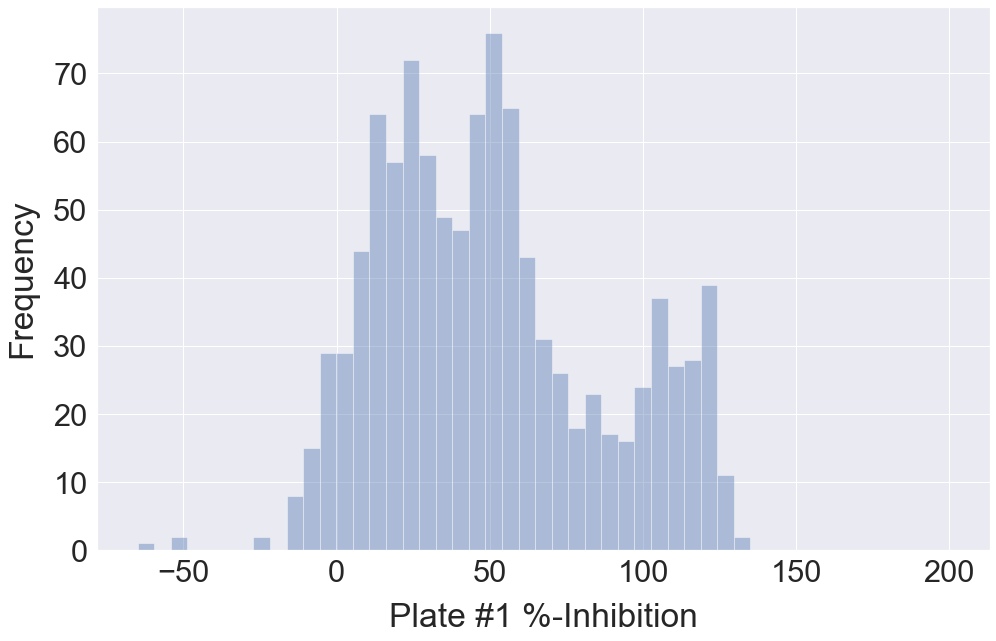

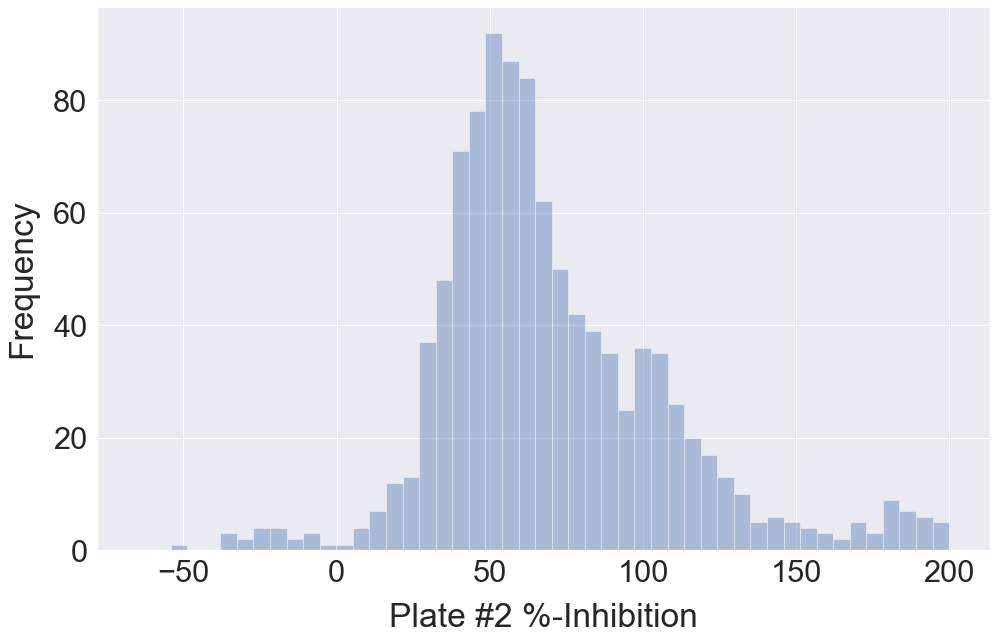

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper");sns.set(font_scale=2.8);figsize=(16, 10)

kde=False
bin_range=np.linspace(-65, 200, 50)
plt.figure(figsize=figsize)
sns.distplot(res_df['Replicate1'], bins=bin_range, norm_hist=False, kde=kde)
plt.ylabel('Frequency', labelpad=15)
plt.xlabel('Plate #1 %-Inhibition', labelpad=15)
plt.show()
plt.figure(figsize=figsize)
sns.distplot(res_df['Replicate2'], bins=bin_range, norm_hist=False, kde=kde)
plt.ylabel('Frequency', labelpad=15)
plt.xlabel('Plate #2 %-Inhibition', labelpad=15)
plt.show()

In [5]:
res_df[['Replicate1', 'Replicate2']].describe()

,Replicate1,Replicate2
count,1024.000000,1024.000000
mean,50.208504,70.127521
std,36.794831,38.163735
min,-60.100000,-49.700000
25%,21.975000,45.800000
50%,46.150000,61.800000
75%,71.925000,89.900000
max,131.000000,200.000000


In [6]:
weak_active = (res_df['Replicate1'] >= 35.0) & (res_df['Replicate2'] >= 35.0) # close to 40th percentile of Replicate1
normal_active = (res_df['Replicate1'] >= 50.0) & (res_df['Replicate2'] >= 50.0)
strong_active = (res_df['Replicate1'] >= 72.0) & (res_df['Replicate2'] >= 72.0) # close to 75th percentile of Replicate1

res_df['active_type'] = 'none'
res_df.loc[weak_active & (res_df['PAINS Filter']), 'active_type'] = 'weak'
res_df.loc[normal_active & (res_df['PAINS Filter']), 'active_type'] = 'normal'
res_df.loc[strong_active & (res_df['PAINS Filter']), 'active_type'] = 'strong'

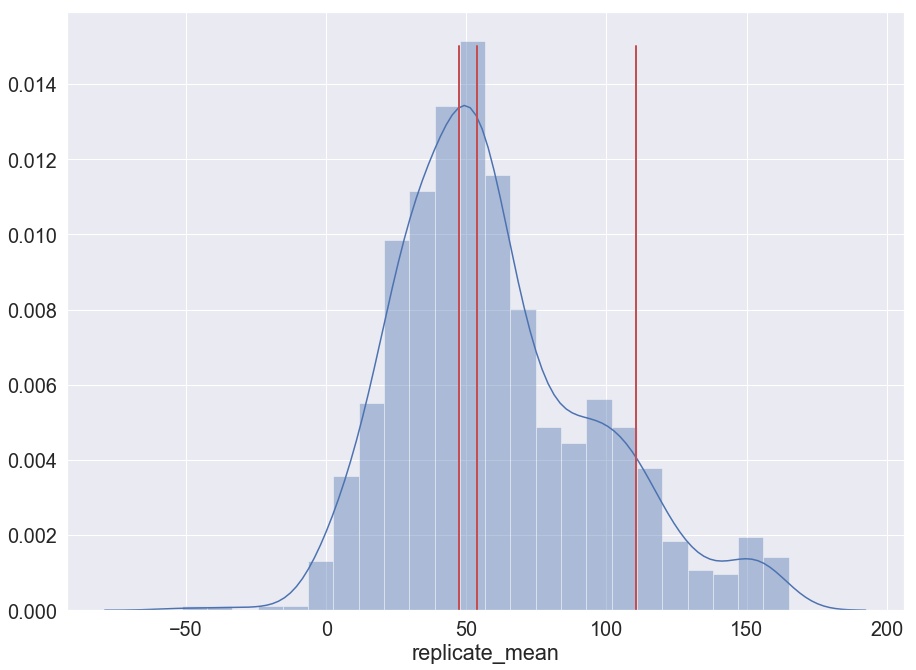

In [7]:
res_df['replicate_mean'] = res_df[['Replicate1', 'Replicate2']].mean(axis=1)

plt.figure(figsize=(15,11))
sns.distplot(res_df['replicate_mean'])

plt.plot([res_df['replicate_mean'].quantile(0.9), res_df['replicate_mean'].quantile(0.9)], [0, 0.015], color='r', linewidth=2)

plt.plot([res_df['replicate_mean'].quantile(0.5), res_df['replicate_mean'].quantile(0.5)], [0, 0.015], color='r', linewidth=2)

plt.plot([res_df['replicate_mean'].quantile(0.40), res_df['replicate_mean'].quantile(0.40)], [0, 0.015], color='r', linewidth=2)

plt.show()

---
## Hits by Selection/Model Type

In [8]:
RF_all = res_df[res_df['Selection'].isin(['Prediction', 'Both'])]
BL_all = res_df[res_df['Selection'].isin(['Baseline', 'Both'])]
RF_but_not_BL = res_df[res_df['Selection'].isin(['Prediction'])]
BL_but_not_RF = res_df[res_df['Selection'].isin(['Baseline'])]
overlap_selection =  res_df[res_df['Selection'] == 'Both']

summary_by_selection = []
for df in [res_df, RF_all, BL_all, overlap_selection, RF_but_not_BL, BL_but_not_RF]:
    strong_actives = df[(df['active_type'] == 'strong')].shape[0]
    normal_actives = df[(df['active_type'] == 'normal')].shape[0]
    weak_actives = df[(df['active_type'] == 'weak')].shape[0] 
    summary_by_selection.append([df.shape[0], df['Hit'].sum(), strong_actives, normal_actives, weak_actives])
    
index_names = ['RF-C + Baseline', 'RF-C', 'Baseline', 
               'RF-C AND Baseline (overlap)', 'RF-C - Baseline', 'Baseline - RF-C']
summary_df = pd.DataFrame(data=summary_by_selection,
                          columns=['Count', 'Hits', 'Strong Actives', 'Normal Actives', 'Weak Actives'],
                          index=index_names)

summary_df['Misses'] = summary_df['Count'] - summary_df['Hits']
summary_df['Hit Rate'] = 100.0*(summary_df['Hits'] / summary_df['Count'])
summary_df

,Count,Hits,Strong Actives,Normal Actives,Weak Actives,Misses,Hit Rate
RF-C + Baseline,1024,412,221,191,178,612,40.234375
RF-C,701,337,208,129,110,364,48.074180
Baseline,705,256,111,145,146,449,36.312057
RF-C AND Baseline (overlap),382,181,98,83,78,201,47.382199
RF-C - Baseline,319,156,110,46,32,163,48.902821
Baseline - RF-C,323,75,13,62,68,248,23.219814


---
## Look at clusters/novel hits

In [27]:
train_hits = train_df[train_df['PriA-SSB AS Activity'] == 1]

cluster_cols = 'TB_0.4 ID'
clusters = res_df[cluster_cols].unique()

cluster_info = []
for cluster_id in clusters:
    df = res_df[res_df[cluster_cols] == cluster_id]
    
    strong_actives = df[df['active_type'] == 'strong'].shape[0]
    normal_actives = df[df['active_type'] == 'normal'].shape[0]
    weak_actives = df[df['active_type'] == 'weak'].shape[0]
    
    cluster_info.append([cluster_id, strong_actives, normal_actives, weak_actives])
    
cluster_df = pd.DataFrame(cluster_info, 
                          columns=['Cluster ID', 'Strong Actives', 'Normal Actives', 'Weak Actives'])

cluster_df['Total'] = cluster_df[['Strong Actives', 'Normal Actives', 'Weak Actives']].sum(axis=1)
cluster_df = cluster_df[cluster_df['Total'] > 0]
total_clusters = cluster_df.shape[0]
clusters_with_strong_actives = cluster_df[cluster_df['Strong Actives'] > 0].shape[0]
clusters_with_normal_actives = cluster_df[cluster_df['Normal Actives'] > 0].shape[0]
clusters_with_weak_actives = cluster_df[cluster_df['Weak Actives'] > 0].shape[0]
clusters_with_strong_or_normal_actives = cluster_df[(cluster_df['Strong Actives'] > 0) | (cluster_df['Normal Actives'] > 0)].shape[0]
print('Fraction of clusters with at least 1 strong active among active clusters: {:.2f}'.format(clusters_with_strong_actives/total_clusters))
print('Fraction of clusters with at least 1 normal active among active clusters: {:.2f}'.format(clusters_with_normal_actives/total_clusters))
print('Fraction of clusters with at least 1 weak active among active clusters: {:.2f}'.format(clusters_with_weak_actives/total_clusters))
print('Fraction of clusters with at least 1 strong or normal active among active clusters: {:.2f}'.format(clusters_with_strong_or_normal_actives/total_clusters))

cluster_df = cluster_df.sort_values('Total', ascending=False).reset_index(drop=True)
rows_total = cluster_df.sum(axis=0).to_frame().T
rows_total.index = ['Total']
rows_total.iloc[0,0] = '-'
cluster_df = pd.concat([cluster_df, rows_total])
display(cluster_df)

Fraction of clusters with at least 1 strong active among active clusters: 0.49
Fraction of clusters with at least 1 normal active among active clusters: 0.45
Fraction of clusters with at least 1 weak active among active clusters: 0.42
Fraction of clusters with at least 1 strong or normal active among active clusters: 0.79


,Cluster ID,Strong Actives,Normal Actives,Weak Actives,Total
0,12,45,12,13,70
1,341,0,20,16,36
2,483,3,12,2,17
3,1814,11,3,2,16
4,362,4,6,6,16
5,339,0,4,10,14
6,18,2,4,7,13
7,1534,0,6,6,12
8,142,4,5,3,12
9,3321,8,1,2,11


In [10]:
from scipy.stats import chi2_contingency, chisquare
ctable = cluster_df.iloc[:-1,1:4].values

chi2, p2, dof, ex = chi2_contingency(ctable, correction=True, lambda_=None)
print(chi2, p2, dof, 169 * 5)
chi, p = chisquare(ctable)
print(chi, p)

573.4660850958339 3.070061593298334e-06 428 845
[2251.01357466  976.30366492  863.17977528] [0.00000000e+00 1.07619208e-97 8.77254936e-79]


In [ ]:
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects import numpy2ri
numpy2ri.activate()
rpy2.robjects.r['options'](warn=-1)
install_packages = False

utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages('stats')
        
ctable = cluster_df.iloc[:-1,1:4].values
stats = rpackages.importr('stats')
res = stats.fisher_test(ctable, workspace=2e8, hybrid=False,
                        alternative="two.sided", conf_level=0.95,
                        simulate_p_value=True)
res

In [12]:
res[0][0]

0.0004997501249375312

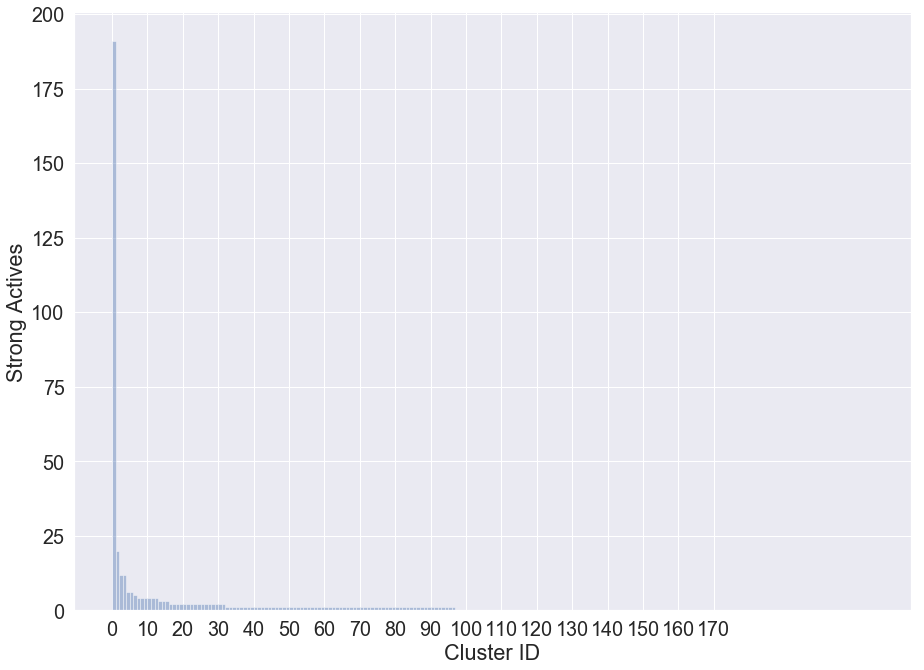

In [14]:
cluster_df = cluster_df.sort_values('Normal Actives', ascending=False).reset_index(drop=True)

cluster_bins = []
cidx = 0
for idx, row in cluster_df.iterrows():
    reps = row['Normal Actives']
    cluster_bins.append(np.repeat(cidx, reps))
    cidx += 1

cluster_bins = np.hstack(cluster_bins)

plt.figure(figsize=(15,11))
sns.distplot(cluster_bins, bins=np.arange(cluster_df.shape[0]), norm_hist=False, kde=False)
plt.xlabel('Cluster ID')
plt.ylabel('Strong Actives')
#plt.yticks([i for i in range(20)])
plt.xticks([10*i for i in range(18)])
plt.show()

In [209]:
cluster_df.sum()

Cluster ID        11111794
Strong Actives         103
Normal Actives         304
Weak Actives             5
Total                  412
dtype: int64